## 5-1 文本生成

In [2]:
import torch
import tiktoken
from gpt_model import GPTModel, GPT_CONFIG_124M, token_ids_to_text, text_to_token_ids

torch.Size([2, 6, 3])


In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                                        [40, 1107, 588]])  # "I really like"]

targets = torch.tensor([[3626, 6100, 345],  # [" effort moves you",
                                      [1107, 588, 11311]]) # " really like chocolate"]

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)  # 批次大小, 每行词元数量, 嵌入维度

torch.Size([2, 3, 50257])


In [4]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [5]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
    f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


## 5-2 文本评估

模型训练的目标是增大与正确目标词元 ID 对应的索引位置的 softmax 概率。

1. 模型接收 3 个输入词元并生成 3 个向量
2. 模型生成的张量中的每个向量的索引位置都对应词汇表中的一个单词
3. 一个未训练的模型会为每个词元生成一个随机向量
4. 模型训练时，目标是最大化与目标向量中的词元索引相对应的值

In [6]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


计算概率和目标概率损失步骤：

1. logits
2. 概率
3. 目标概率
4. 对数概率
5. 平均对数概率
6. 负平均对数概率

这个过程叫交叉熵损失。

In [7]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("log_probas:", log_probas)

avg_log_probas = torch.mean(log_probas)
print("avg_log_probas:", avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print("neg_avg_log_probas:", neg_avg_log_probas)

log_probas: tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
avg_log_probas: tensor(-10.7940)
neg_avg_log_probas: tensor(10.7940)


In [8]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Falttened targets:", targets_flat.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Falttened targets: torch.Size([6])


In [9]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


## 5-3 计算训练集和验证集的损失

In [10]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [11]:
train_ratio = 0.9 # 训练集占数据集中的比例，这里是 90% 训练集，10% 验证集
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx] # 训练集
val_data = text_data[split_idx:]   # 验证集

In [12]:
from data_loader import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """计算给定批次的交叉熵损失"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten(),
    )
    return loss

In [14]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    """用于计算训练集和验证集损失"""
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583372328016
Validation loss: 10.98110580444336


## 5-4 训练大模型

1、遍历训练轮次

        2、在每个训练轮次中遍历批次

            3、从上个批次迭代中重置损失梯度

            4、计算当前批次的损失

            5、反向传播以计算损失梯度

            6、使用损失梯度更新模型权重

            7、打印训练集和验证集的损失（可选）

        8、生成本文样本养鱼可视化（可选）
    
回到 1

In [16]:
from gpt_model import generate_text_simple

def train_model_simple(model, train_loader, val_loader,
                    optimizer, device, num_epochs,
                    eval_freq, eval_iter, start_context, tokenizer):
    
    # 初始化列表以跟踪损失和所见的词元
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 开始主训练循环
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            # 重置上一个批次迭代中的损失梯度
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device,
            )
            # 计算损失梯度
            loss.backward()
            # 使用损失梯度更新模型权重
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选的评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}")

        if epoch % 3 == 0:
            generate_and_print_sample(
                model, tokenizer, device, start_context
            )
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """评估模型"""

    # 在评估阶段禁用 dropout，以产出稳定且可复现的结果
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    """生成文本并打印"""

    # 进入评估模式，禁用 Dropout 层、禁用 BatchNorm 层的统计更新、禁用 梯度计算
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_length=context_size,
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))

    # 进入训练模式，启用 Dropout 层、启用 BatchNorm 层的统计更新、启用 梯度计算
    model.train()

### AdamW 优化器概述

`AdamW` 是 Adam 优化器的一个改进版本，它在 Adam 的基础上加入了**权重衰减（Weight Decay）**的正确实现。

#### 参数详解

##### 1. **`model.parameters()`**
```python
model.parameters()
```
- **作用**：获取模型中所有需要训练的参数
- **包含**：权重矩阵、偏置向量、嵌入层参数等
- **自动更新**：优化器会自动更新这些参数

##### 2. **`lr=0.0004` (学习率)**
```python
lr=0.0004  # 0.0004 = 4e-4
```
- **含义**：每次参数更新的步长大小
- **选择原因**：
  - 对于 GPT 模型，这是一个常用的学习率
  - 不会太大（避免训练不稳定）
  - 不会太小（避免训练过慢）
- **经验值**：大模型通常使用 1e-4 到 1e-3 之间的学习率

##### 3. **`weight_decay=0.1` (权重衰减)**
```python
weight_decay=0.1
```
- **作用**：L2 正则化，防止过拟合
- **原理**：在损失函数中添加权重平方和的惩罚项
- **公式**：`loss = original_loss + 0.1 * Σ(w²)`
- **效果**：鼓励权重值接近 0，提高泛化能力

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer,
)

Ep 1 (Step 000000):Train loss 10.789, Val loss 10.765
Ep 1 (Step 000005):Train loss 8.463, Val loss 8.634
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010):Train loss 6.925, Val loss 7.268
Ep 2 (Step 000015):Train loss 6.272, Val loss 6.684
Ep 3 (Step 000020):Train loss 6.095, Val loss 6.651
Ep 3 (Step 000025):Train loss 5.970, Val loss 6.686
Ep 4 (Step 000030):Train loss 5.928, Val loss 6.689
Ep 4 (Step 000035):Train loss 5.874, Val loss 6.685
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000040):Train loss 5.633, Val loss 6.668
Ep 6 (Step 000045):Train loss 5.756, Val loss 6.710
Ep 6 (Step 000050):Train loss 5.623, Val loss 6.621
Ep 7 (Step 000055):Train loss 5.640, Val loss 6.721
Ep 7 (Step 000060):Train loss 5.668, Val loss 6.715
Every effort moves you, and, and, I had                                           
Ep 8 (Step 000065):Train loss 5.511, Val loss 6.629
Ep 8 (Step 000070):Train loss 5.122, Val 

### 打印损失曲线

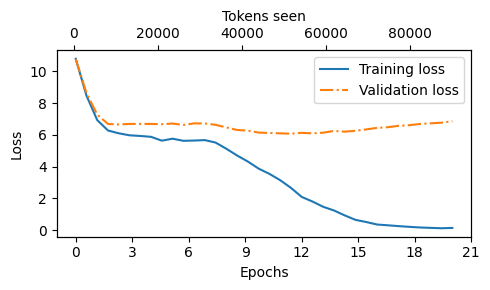

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses = plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 6-5 文本生成策略

1. 温度缩放：温度越低越稳定，越高越随机
2. top-k 采样：k 越小越稳定，越大越随机


In [27]:
torch.manual_seed(123)
model.to("cpu")
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("I seemed to see", tokenizer),
    max_new_tokens=25,
    context_length=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I seemed to see it. Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to


In [33]:
def generate(model, idx, max_new_tokens, context_length,
        temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 使用 top_k 采样筛选 logits
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits,
            )
        
        if temperature > 0.0:
            # 使用温度缩放
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # 当不使用温度缩放时，执行贪心解码，选取下一个词元
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # 如果遇到序列结束词元，则提前停止生成
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [34]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("I seemed to see", tokenizer),
    max_new_tokens=15,
    context_length=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I seemed to see. And through my dear in the latter: "interesting deprecating laugh


## 5-6 权重保存和加载

In [35]:
import os

dump_model_file = "model_and_optimizer.pth"

try:
    os.remove(dump_model_file)
except:
    pass

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, dump_model_file)

In [36]:
checkpoint = torch.load(dump_model_file, map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4, weight_decay=0.1,
)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("I seemed to see", tokenizer),
    max_new_tokens=15,
    context_length=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I seemed to see. And through my dear in the latter: "interesting deprecating laugh


## 5-7 加载 OpenAI 预训练权重

In [39]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2",
)

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0

In [40]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [41]:
def assign(left, right):
    """检查 2 个张量或数组是否具有相同的维度或形状，并将 right 张量返回为可训练的 PyTorch 参数"""
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [42]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    """将从 GPT-2 的 params 字典中的权重加载到 GPTModel 的 gpt 实例的"""
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)
max_new_tokens = 25
for i in range(max_new_tokens):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
        max_new_tokens=i+1,
        context_length=NEW_CONFIG["context_length"],
        top_k=None,
        temperature=0.0,
    )
    print(token_ids_to_text(token_ids, tokenizer).replace('\n', " "))

Every effort moves you forward
Every effort moves you forward.
Every effort moves you forward. 
Every effort moves you forward.  
Every effort moves you forward.  The
Every effort moves you forward.  The first
Every effort moves you forward.  The first step
Every effort moves you forward.  The first step is
Every effort moves you forward.  The first step is to
Every effort moves you forward.  The first step is to understand
Every effort moves you forward.  The first step is to understand the
Every effort moves you forward.  The first step is to understand the importance
Every effort moves you forward.  The first step is to understand the importance of
Every effort moves you forward.  The first step is to understand the importance of your
Every effort moves you forward.  The first step is to understand the importance of your work
Every effort moves you forward.  The first step is to understand the importance of your work.
Every effort moves you forward.  The first step is to understand 

### 6 使用学习率预热、余弦衰减、梯度裁剪来优化训练过程

- 学习率预热 (Warmup)：解决训练初期的不稳定性。
- 余弦衰减 (Cosine Annealing)：解决训练中后期的精细调整和收敛问题。
- 梯度裁剪 (Gradient Clipping)：解决训练过程中可能出现的梯度爆炸问题，充当“安全带”。

In [30]:
import math

def train_model(model, train_loader, val_loader, optimizer, device,
                num_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * num_epochs # 计算训练过程中的所有迭代步数
    lr_increment = (peak_lr - initial_lr) / warmup_steps  # 计算在预热阶段学习率的增量

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            global_step +=1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment    # 学习率预热阶段
            else:
                progress = ((global_step - warmup_steps) /
                                    (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (      # 余弦衰减阶段
                    1 + math.cos(math.pi * progress))
            for param_group in optimizer.param_groups:  # 在优化器上应用计算后的学习率
                param_group["lr"] = lr
            track_lrs.append(lr)

            # 计算交叉熵损伤并反向传播
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step >= warmup_steps: # 在预热阶段后使用梯度裁剪来避免梯度爆炸
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=1.0
                )
            
            optimizer.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen, track_lrs